In [1]:
#@title Imports

import jax.numpy as np
import numpy as onp
from jax import jit
from jax import random
from jax import lax
import jax_md

from jax.config import config
config.update('jax_enable_x64', True)

from jax_md import space
from jax_md import energy
from jax_md import simulate
from jax_md import quantity
from jax_md import partition

# from jax_md.colab_tools import renderer

In [2]:
lattice_constant = 1.37820
N_rep = int(10000 ** (1/3))
box_size = N_rep * lattice_constant * 2
# Using float32 for positions / velocities, but float64 for reductions.
dtype = np.float32

# Specify the format of the neighbor list. 
# Options are Dense, Sparse, or OrderedSparse. 
format = partition.OrderedSparse

displacement, shift = space.periodic(box_size)

In [3]:
R = []
for i in range(N_rep):
  for j in range(N_rep):
    for k in range(N_rep):
      R += [[i, j, k]]
R = np.array(R, dtype=dtype) * lattice_constant

In [4]:
N = R.shape[0]
phi = N / (box_size) ** 3
print(f'Created a system of {N} LJ particles with number density {phi:.3f}')

Created a system of 9261 LJ particles with number density 0.048


In [13]:
neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement,
                                                            box_size, 
                                                            r_cutoff=2.5,
                                                            epsilon=1.0,
                                                            sigma=1.0,
                                                            dr_threshold=1.,
                                                            format=format)

In [14]:
nbrs = neighbor_fn.allocate(R)
energy_fn(R, nbrs)

/opt/homebrew/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Array(-16904.852, dtype=float32)

In [15]:
init, apply = simulate.nvt_nose_hoover(energy_fn, shift, 5e-3, kT=0.75)

FOO


In [16]:
key = random.PRNGKey(0)

# We pick an "extra capacity" to ensure ahead of time that the neighbor
# list will have enough capacity. Since sparse neighbor lists are more 
# robust to changes in the number of particles, in this case we only 
# need to actually add more capacity for dense neighbor lists.
if format is partition.Dense: 
  nbrs = neighbor_fn.allocate(R, extra_capacity=55)
else:
  nbrs = neighbor_fn.allocate(R)

state = init(key, R, neighbor=nbrs)

In [17]:
def step(state_and_nbrs, unused):
  state, nbrs = state_and_nbrs
  nbrs = nbrs.update(state.position)
  return (apply(state, neighbor=nbrs), nbrs), energy_fn(state.position, nbrs)


In [18]:
(new_state, new_nbrs), energies = lax.scan(step, (state, nbrs), np.ones((2000)))


In [ ]:
(energies/N)[1000:].mean()
# energies

Array(-6.23089, dtype=float32)

In [21]:
energy_fn(R, nbrs)
# R.shape
# Array(0.16502948, dtype=float32)


Array(0., dtype=float32)

In [16]:
new_nbrs

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)

In [47]:
ran = np.linspace(1e-6, 1e-5, num = 100)
gr = jax_md.quantity.pair_correlation(displacement, ran, 1.0)

In [48]:
# gr(state.position).shape
# state.position.shape
# np.logspace(0.1,1.0)

(512, 100)

<Axes: >

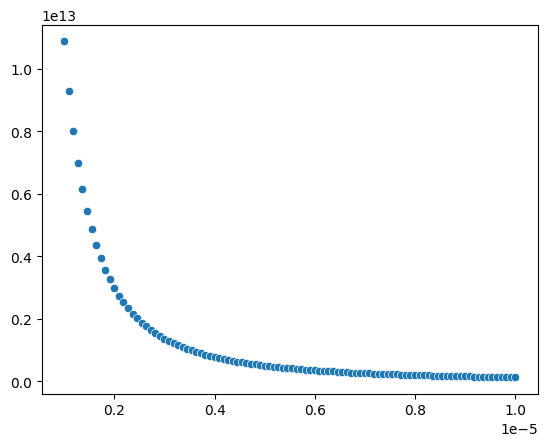

In [49]:
import seaborn as sns
sns.scatterplot(x=ran, y=np.mean(gr(state.position),axis=0))